In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

In [2]:
!nvidia-smi

Thu Aug 13 07:18:00 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 440.82       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Quadro GV100        Off  | 00000000:37:00.0 Off |                  Off |
| 30%   43C    P2    35W / 250W |   1330MiB / 32508MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

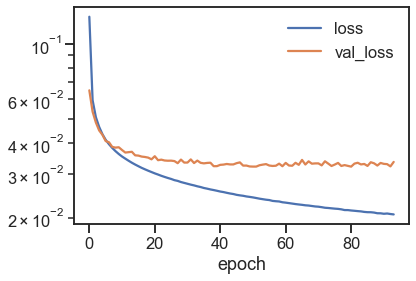

In [3]:
pd.read_csv('20200812_kl_divergence_faster_lr/log.csv').set_index('epoch').plot()
plt.yscale('log')

In [4]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
import nfp

In [5]:
from preprocess_inputs import preprocessor
preprocessor.from_json('tfrecords/preprocessor.json')

from loss import AtomInfMask, KLWithLogits

model = tf.keras.models.load_model(
    '20200812_kl_divergence_faster_lr/best_model.hdf5',
    custom_objects={**nfp.custom_objects,
                    **{'AtomInfMask': AtomInfMask, 'KLWithLogits': KLWithLogits}})

In [6]:
cdf = pd.read_csv('/projects/rlmolecule/pstjohn/atom_spins/cdf_spins.csv.gz')
test = np.load('split.npz', allow_pickle=True)['test']

In [7]:
cdf_test = cdf[cdf.smiles.isin(test)].copy()
cdf_test['fractional_spin'] = cdf_test.groupby('smiles').spin.apply(lambda x: x.abs() / x.abs().sum())
cdf_test_pivot = cdf_test.pivot(index='smiles', columns='atom_index', values='fractional_spin')
cdf_test_pivot = cdf_test_pivot.reindex(test)
cdf_test_pivot.head()

atom_index,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
smiles,,,,,,,,,,,,,,,,,,,,,
CO/[C]=C1/CCCCC1=O,0.001776,0.103081,0.702058,0.109981,0.001902,0.002830,0.001808,0.005006,0.042844,0.010367,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C[CH]C[C@@H]1COOO1,0.047013,0.718680,0.057055,0.019739,0.001834,0.000174,0.000294,0.000185,0.005816,0.043117,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CC[C@@H](F)C(=[N])N,0.000306,0.000109,0.074523,0.005681,0.122172,0.762786,0.020510,0.000498,0.000044,0.000007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
[CH2]Nc1ccc(C)c(Cl)c1,0.597656,0.083265,0.045439,0.047257,0.023602,0.053582,0.002519,0.020194,0.000900,0.065124,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NCc1nc[c]cc1F,0.000266,0.004885,0.036233,0.059242,0.046752,0.721763,0.058991,0.046018,0.003389,0.000182,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
test_dataset = tf.data.Dataset.from_generator(
    lambda: (preprocessor.construct_feature_matrices(smiles, train=False) for smiles in test),
    output_types=preprocessor.output_types,
    output_shapes=preprocessor.output_shapes)\
    .padded_batch(batch_size=128, padded_shapes=preprocessor.padded_shapes(max_atoms=cdf_test_pivot.shape[1]),  # explicit padding required for consistent output shape
                  padding_values=preprocessor.padding_values)

In [9]:
predicted_fractional_spins = tf.nn.softmax(model.predict(test_dataset, verbose=True))

     16/Unknown - 2s 99ms/step 

RDKit WARNING: [07:19:43] Conflicting single bond directions around double bond at index 2.
RDKit WARNING: [07:19:43]   BondStereo set to STEREONONE and single bond directions set to NONE.
RDKit WARNING: [07:19:43] Conflicting single bond directions around double bond at index 2.
RDKit WARNING: [07:19:43]   BondStereo set to STEREONONE and single bond directions set to NONE.


40/40 [==============================] - 5s 113ms/step


Text(0, 0.5, 'Predicted fractional spin')

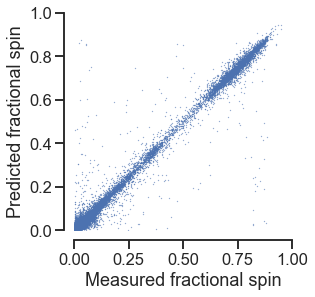

In [10]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, aspect='equal')
ax.plot(cdf_test_pivot.values.flatten(), predicted_fractional_spins.numpy().flatten(), '.', ms=.5)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
sns.despine(trim=True, offset=10)
ax.set_xlabel('Measured fractional spin')
ax.set_ylabel('Predicted fractional spin')

Text(0, 0.5, 'Fractional Spin MAE')

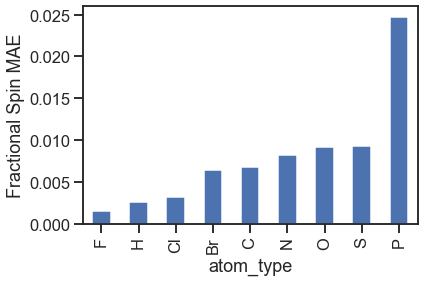

In [11]:
df_pred = pd.DataFrame(predicted_fractional_spins.numpy(), index=test).reset_index().melt(id_vars=['index']).rename(
    columns={'variable': 'atom_index', 'value': 'predicted_fractional_spin', 'index': 'smiles'})

cdf_test_merged = cdf_test.merge(df_pred, on=['smiles', 'atom_index'], how='left')
cdf_test_merged['abs_err'] = (cdf_test_merged['fractional_spin'] - cdf_test_merged['predicted_fractional_spin']).abs()

cdf_test_merged.groupby('atom_type').abs_err.mean().sort_values().plot.bar()
plt.ylabel('Fractional Spin MAE')

## Drawing outliers

In [142]:
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)
from IPython.display import SVG
from collections import defaultdict

pred_spin_df = cdf_test_merged.set_index(['smiles', 'atom_index'])

def draw(smiles, thres=0.25):

    mol = rdkit.Chem.MolFromSmiles(smiles)

    atomHighlights = defaultdict(list)

    colors = {'DFT':(1,0,0),
              'ML':(0,0,1),
              'rad':(0,1,0)
             }

    for atom in mol.GetAtoms():

        row = pred_spin_df.loc[smiles, atom.GetIdx()]
        if row.fractional_spin > thres:
            atomHighlights[atom.GetIdx()].append(colors['DFT'])

        if row.predicted_fractional_spin > thres:
            atomHighlights[atom.GetIdx()].append(colors['ML'])       

        if atom.GetNumRadicalElectrons() > 0:
            atomHighlights[atom.GetIdx()].append(colors['rad'])       


    d2d = rdMolDraw2D.MolDraw2DSVG(600,280,300,280)
    dos = d2d.drawOptions()
    dos.atomHighlightsAreCircles = True
    dos.fillHighlights=False

    d2d.DrawMoleculeWithHighlights(mol,smiles,dict(atomHighlights),{},{},{})
    d2d.FinishDrawing()
    return SVG(d2d.GetDrawingText())

In [58]:
cdf_test_merged.sort_values('abs_err', ascending=False).drop_duplicates(subset='smiles', keep='first').head(10)

,smiles,atom_type,atom_index,spin,fractional_spin,predicted_fractional_spin,abs_err
7444,Cc1nc(CC([O])=O)co1,O,6,0.031001,0.028549,0.875540,0.846990
94584,[O]C(=O)C[C@@H]1CO1,O,2,0.949535,0.880171,0.033733,0.846438
75746,CO[C@H]1COC[C@H]1C([O])=O,O,8,0.058870,0.050901,0.858653,0.807753
89719,O=c1cnc2[c][nH]ccn1-2,C,5,-0.067202,0.055085,0.853996,0.798911
29044,C=C(C([O])=O)[C@H](C)CC,O,4,0.940387,0.819364,0.029781,0.789583
15466,C=C/C=C(\C#N)C([O])=O,O,8,0.953606,0.820587,0.095183,0.725405
85186,N[C@H](O)CC([O])=O,O,6,0.950731,0.870983,0.192041,0.678942
76682,COC(=O)c1[c]c(O)cs1,C,5,0.968328,0.832611,0.182034,0.650577
3021,CC1CCC(C([O])=O)CC1,O,7,0.946257,0.838589,0.204745,0.633844
25864,CCCn1[c]c(N)nn1,C,4,0.972479,0.852591,0.227463,0.625128


* Red: DFT
* Blue: ML
* Green: Formal radical center

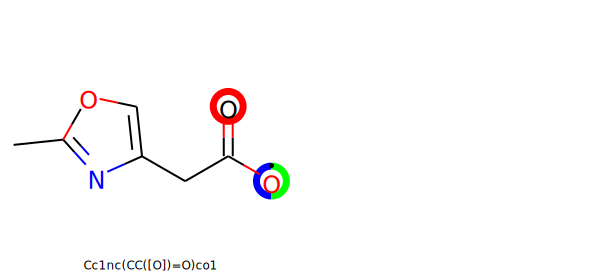

In [60]:
draw('Cc1nc(CC([O])=O)co1')

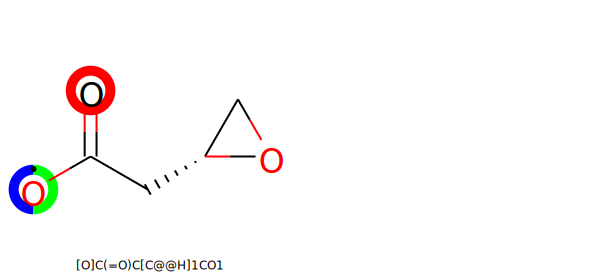

In [61]:
draw('[O]C(=O)C[C@@H]1CO1')

Looks like there's some problem with carboxylic acid radicals. Let's pull all of them to see how we do on average

In [68]:
from tqdm import tqdm
tqdm.pandas()

/projects/rlmolecule/pstjohn/envs/tf2_gpu/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [121]:
patt = Chem.MolFromSmarts('[OX1v1+0]C(=O)')  # https://www.daylight.com/dayhtml_tutorials/languages/smarts/smarts_examples.html#RAD
unique_mols = pd.Series(cdf_test.smiles.unique())
is_carboxylic_acid = unique_mols.progress_apply(lambda x: Chem.MolFromSmiles(x).HasSubstructMatch(patt))

 42%|████▏     | 2124/5000 [00:00<00:01, 2708.06it/s]RDKit WARNING: [08:31:19] Conflicting single bond directions around double bond at index 2.
RDKit WARNING: [08:31:19]   BondStereo set to STEREONONE and single bond directions set to NONE.
 73%|███████▎  | 3666/5000 [00:00<00:00, 3562.12it/s]RDKit WARNING: [08:31:19] Conflicting single bond directions around double bond at index 2.
RDKit WARNING: [08:31:19]   BondStereo set to STEREONONE and single bond directions set to NONE.
100%|██████████| 5000/5000 [00:00<00:00, 12796.67it/s]


Text(0.5, 1.0, 'Just [O]C(=O) Radicals')

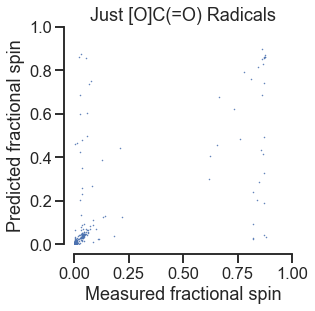

In [122]:
cdf_subset = cdf_test_merged[cdf_test_merged.smiles.isin(unique_mols[is_carboxylic_acid])]

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, aspect='equal')
ax.plot(cdf_subset.fractional_spin, cdf_subset.predicted_fractional_spin, '.', ms=1)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
sns.despine(trim=True, offset=10)
ax.set_xlabel('Measured fractional spin')
ax.set_ylabel('Predicted fractional spin')
ax.set_title('Just [O]C(=O) Radicals')

Yup; not great here

In [123]:
cdf_subset[cdf_subset.fractional_spin > .5].head(10)

,smiles,atom_type,atom_index,spin,fractional_spin,predicted_fractional_spin,abs_err
3021,CC1CCC(C([O])=O)CC1,O,7,0.946257,0.838589,0.204745,0.633844
5349,C[C@]1(CC([O])=O)C[C@@]1(F)Cl,O,4,0.956261,0.866659,0.829333,0.037326
7445,Cc1nc(CC([O])=O)co1,O,7,0.945665,0.870876,0.042366,0.828510
12544,CCC/C=C/CCC([O])=O,O,8,0.949973,0.847514,0.287580,0.559934
13130,C=CCCC(=C)C([O])=O,O,7,0.936550,0.810851,0.759533,0.051318
13961,C/C=C(/CC)C([O])=O,O,6,0.664304,0.622351,0.405127,0.217224
15466,C=C/C=C(\C#N)C([O])=O,O,8,0.953606,0.820587,0.095183,0.725405
16357,CCC[C@H]1C[C@@H]1C([O])=O,O,7,0.951414,0.862795,0.853838,0.008956
28970,C=C(C([O])=O)c1ccoc1,O,4,0.907011,0.819320,0.241989,0.577331
29044,C=C(C([O])=O)[C@H](C)CC,O,4,0.940387,0.819364,0.029781,0.789583


Sometimes it ends up on the formal radical center...

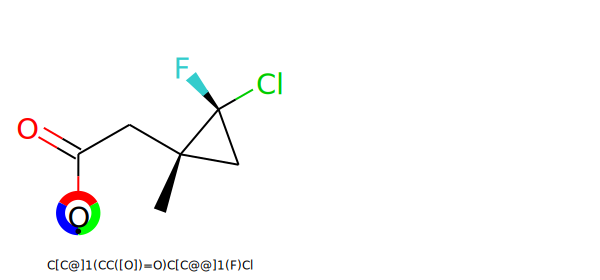

In [124]:
draw('C[C@]1(CC([O])=O)C[C@@]1(F)Cl')

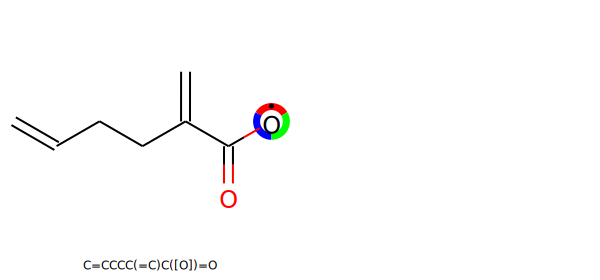

In [125]:
draw('C=CCCC(=C)C([O])=O')

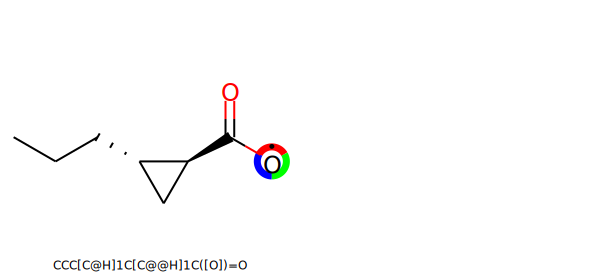

In [126]:
draw('CCC[C@H]1C[C@@H]1C([O])=O')

In [127]:
formal_center = unique_mols.progress_apply(lambda x: [atom.GetIdx() for atom in Chem.MolFromSmiles(x).GetAtoms() if (atom.GetNumRadicalElectrons() == 1)][0])

 68%|██████▊   | 3384/5000 [00:00<00:00, 4236.68it/s]RDKit WARNING: [08:31:28] Conflicting single bond directions around double bond at index 2.
RDKit WARNING: [08:31:28]   BondStereo set to STEREONONE and single bond directions set to NONE.
RDKit WARNING: [08:31:28] Conflicting single bond directions around double bond at index 2.
RDKit WARNING: [08:31:28]   BondStereo set to STEREONONE and single bond directions set to NONE.
100%|██████████| 5000/5000 [00:01<00:00, 4195.56it/s]


In [128]:
formal_center.name = 'atom_index'
radical_center_df = pd.DataFrame(formal_center)
radical_center_df['smiles'] = unique_mols

In [131]:
preds_on_formal_center = radical_center_df.merge(cdf_test_merged, on=['smiles', 'atom_index'], how='left')

Text(0.5, 1.0, 'Predictions on the formal radical center')

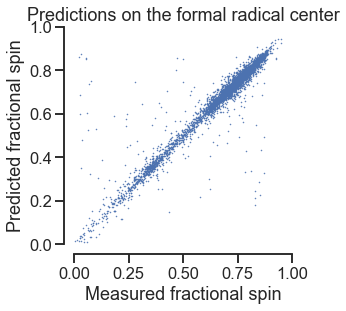

In [133]:
cdf_subset = cdf_test_merged[cdf_test_merged.smiles.isin(unique_mols[is_carboxylic_acid])]

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, aspect='equal')
ax.plot(preds_on_formal_center.fractional_spin, preds_on_formal_center.predicted_fractional_spin, '.', ms=1)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
sns.despine(trim=True, offset=10)
ax.set_xlabel('Measured fractional spin')
ax.set_ylabel('Predicted fractional spin')
ax.set_title('Predictions on the formal radical center')

In [137]:
# what about non carboxylic acid errors
cdf_test_merged[~cdf_test_merged.smiles.isin(unique_mols[is_carboxylic_acid])].sort_values(
    'abs_err', ascending=False).drop_duplicates(subset='smiles', keep='first').head(10)

,smiles,atom_type,atom_index,spin,fractional_spin,predicted_fractional_spin,abs_err
89719,O=c1cnc2[c][nH]ccn1-2,C,5,-0.067202,0.055085,0.853996,0.798911
76682,COC(=O)c1[c]c(O)cs1,C,5,0.968328,0.832611,0.182034,0.650577
25864,CCCn1[c]c(N)nn1,C,4,0.972479,0.852591,0.227463,0.625128
94365,O=C(O)c1[c]c(O)cs1,C,4,0.970942,0.831529,0.212202,0.619328
88570,[O]c1cccc(Cl)c1O,O,0,0.962141,0.831261,0.243010,0.588252
6109,Cc1[c]n(CCO)c(=O)s1,C,2,0.940959,0.813386,0.336151,0.477235
13182,C/C=C(C)/[C]=C\C(=O)OC,C,4,0.474132,0.277424,0.746135,0.468711
82888,N#C/C=C/C(N)=C/[C]=O,C,7,0.107609,0.063891,0.523944,0.460053
72932,CNC(=S)[N]CC(N)=O,S,3,0.982853,0.885857,0.428936,0.456921
77762,C[P+]1CCCCC1,P,1,0.844721,0.783441,0.332062,0.451379


This is a neat one

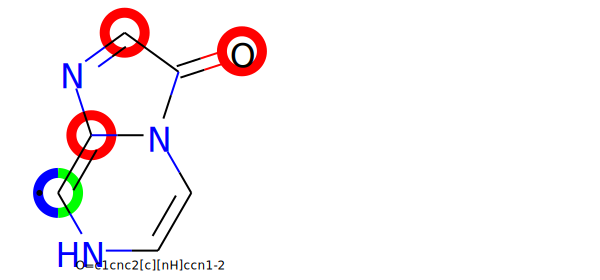

In [145]:
draw('O=c1cnc2[c][nH]ccn1-2', thres=0.15)

What about what we're interested in, spin-delocalized radicals

<AxesSubplot:ylabel='Frequency'>

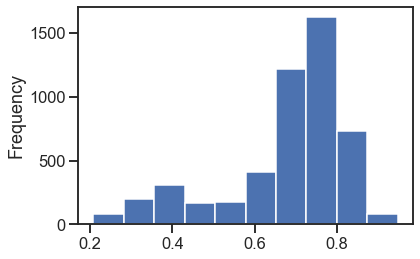

In [157]:
max_spin_by_mol = cdf_test_merged.groupby('smiles').fractional_spin.max()
max_spin_by_mol.plot.hist()

In [156]:
delocalized = cdf_test_merged[cdf_test_merged.smiles.isin(max_spin_by_mol[max_spin_by_mol < 0.5].index)]

Text(0.5, 1.0, 'Predictions on spin-delocalized radicals')

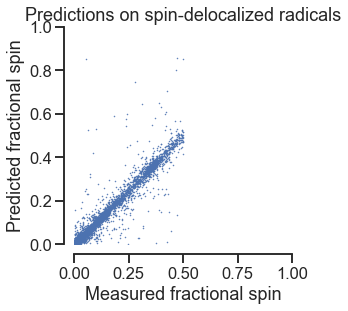

In [160]:
cdf_subset = cdf_test_merged[cdf_test_merged.smiles.isin(unique_mols[is_carboxylic_acid])]

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, aspect='equal')
ax.plot(delocalized.fractional_spin, delocalized.predicted_fractional_spin, '.', ms=1)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
sns.despine(trim=True, offset=10)
ax.set_xlabel('Measured fractional spin')
ax.set_ylabel('Predicted fractional spin')
ax.set_title('Predictions on spin-delocalized radicals')

well, that's reassuring. Looks like we do decently here